In [1]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [2]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P ./Graphics
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P ./Graphics
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P ./Graphics
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P ./Graphics

In [8]:
from latex import latexify
latexify(columns = 2)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
CHECKPOINT_PATH = "../sam-weights/sam_vit_h_4b8939.pth"

In [6]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device = DEVICE)

In [7]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
import os
import cv2
import supervision as sv

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join("./", "Graphics", IMAGE_NAME)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [10]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


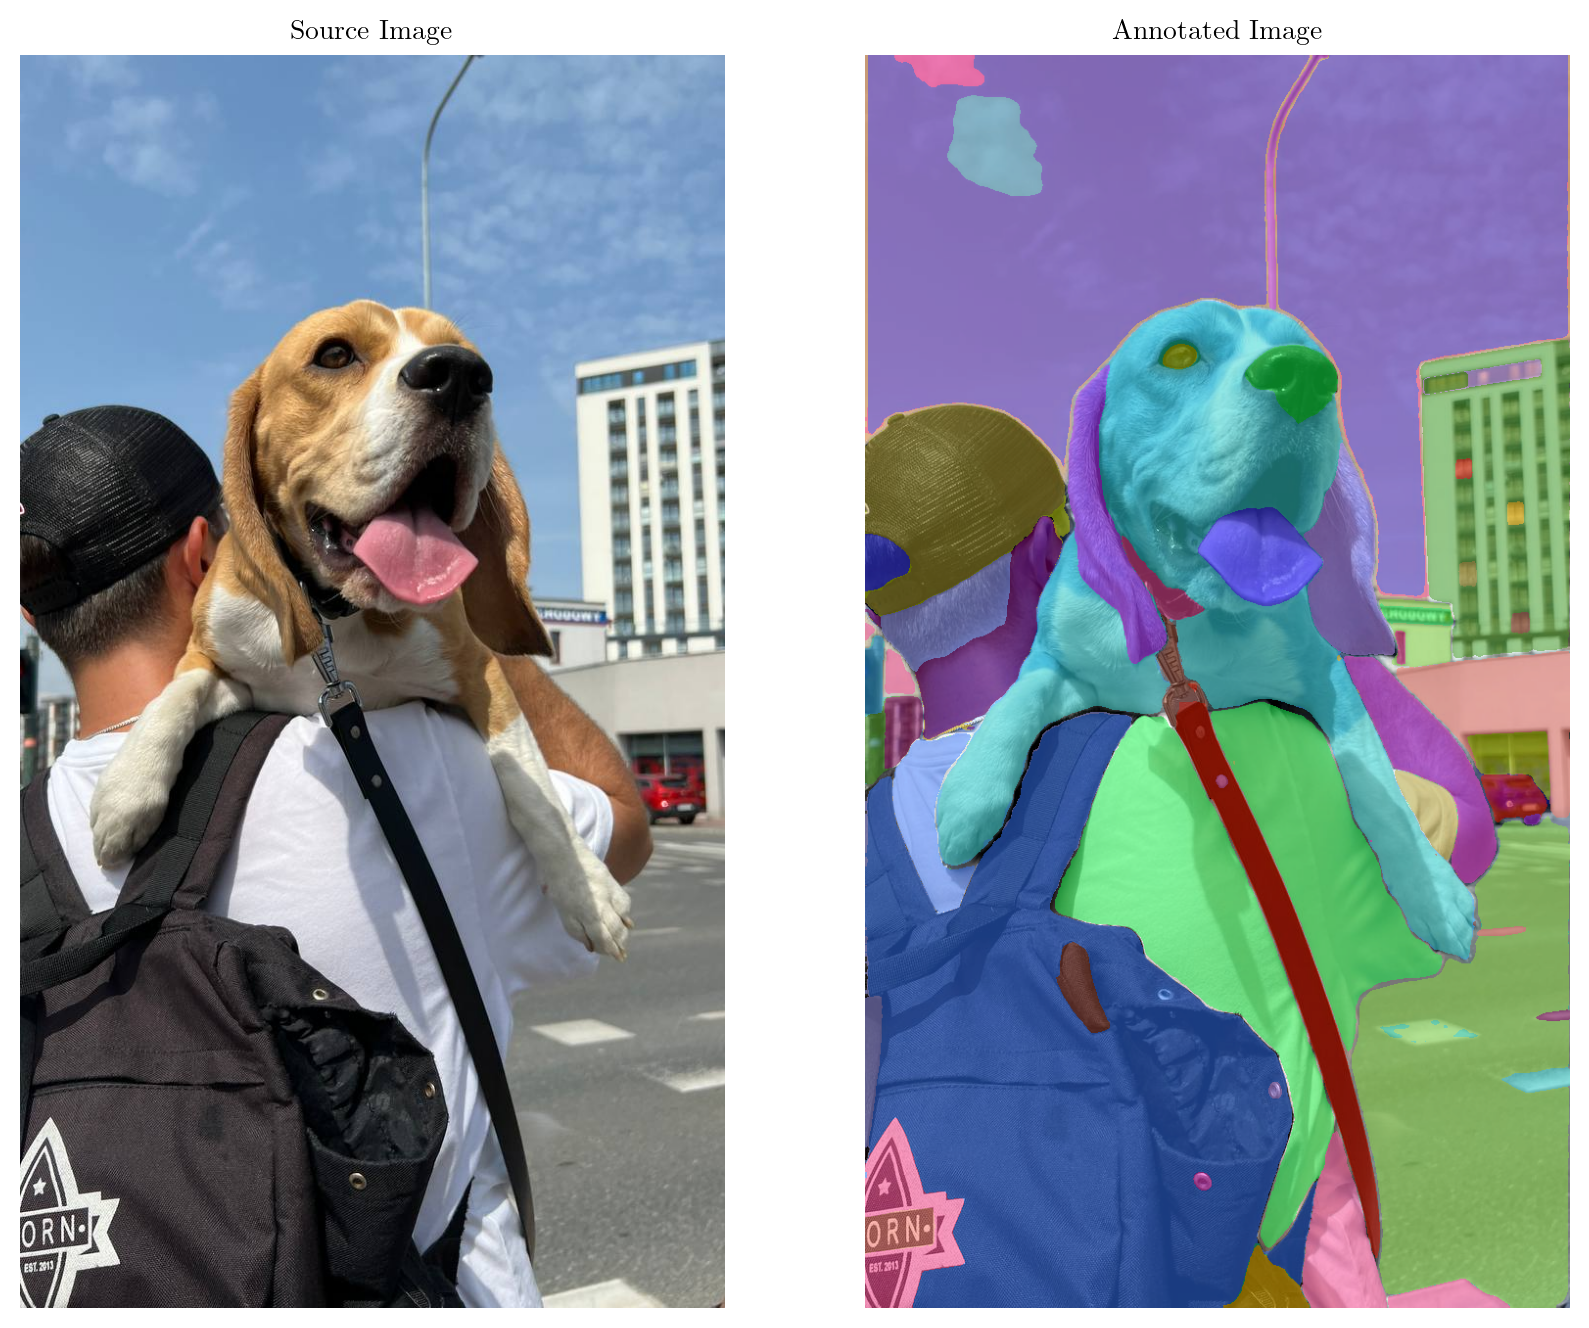

In [12]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Source Image")
plt.subplot(1, 2, 2)
plt.imshow(annotated_image)
plt.axis('off')
plt.title("Annotated Image")
plt.show()

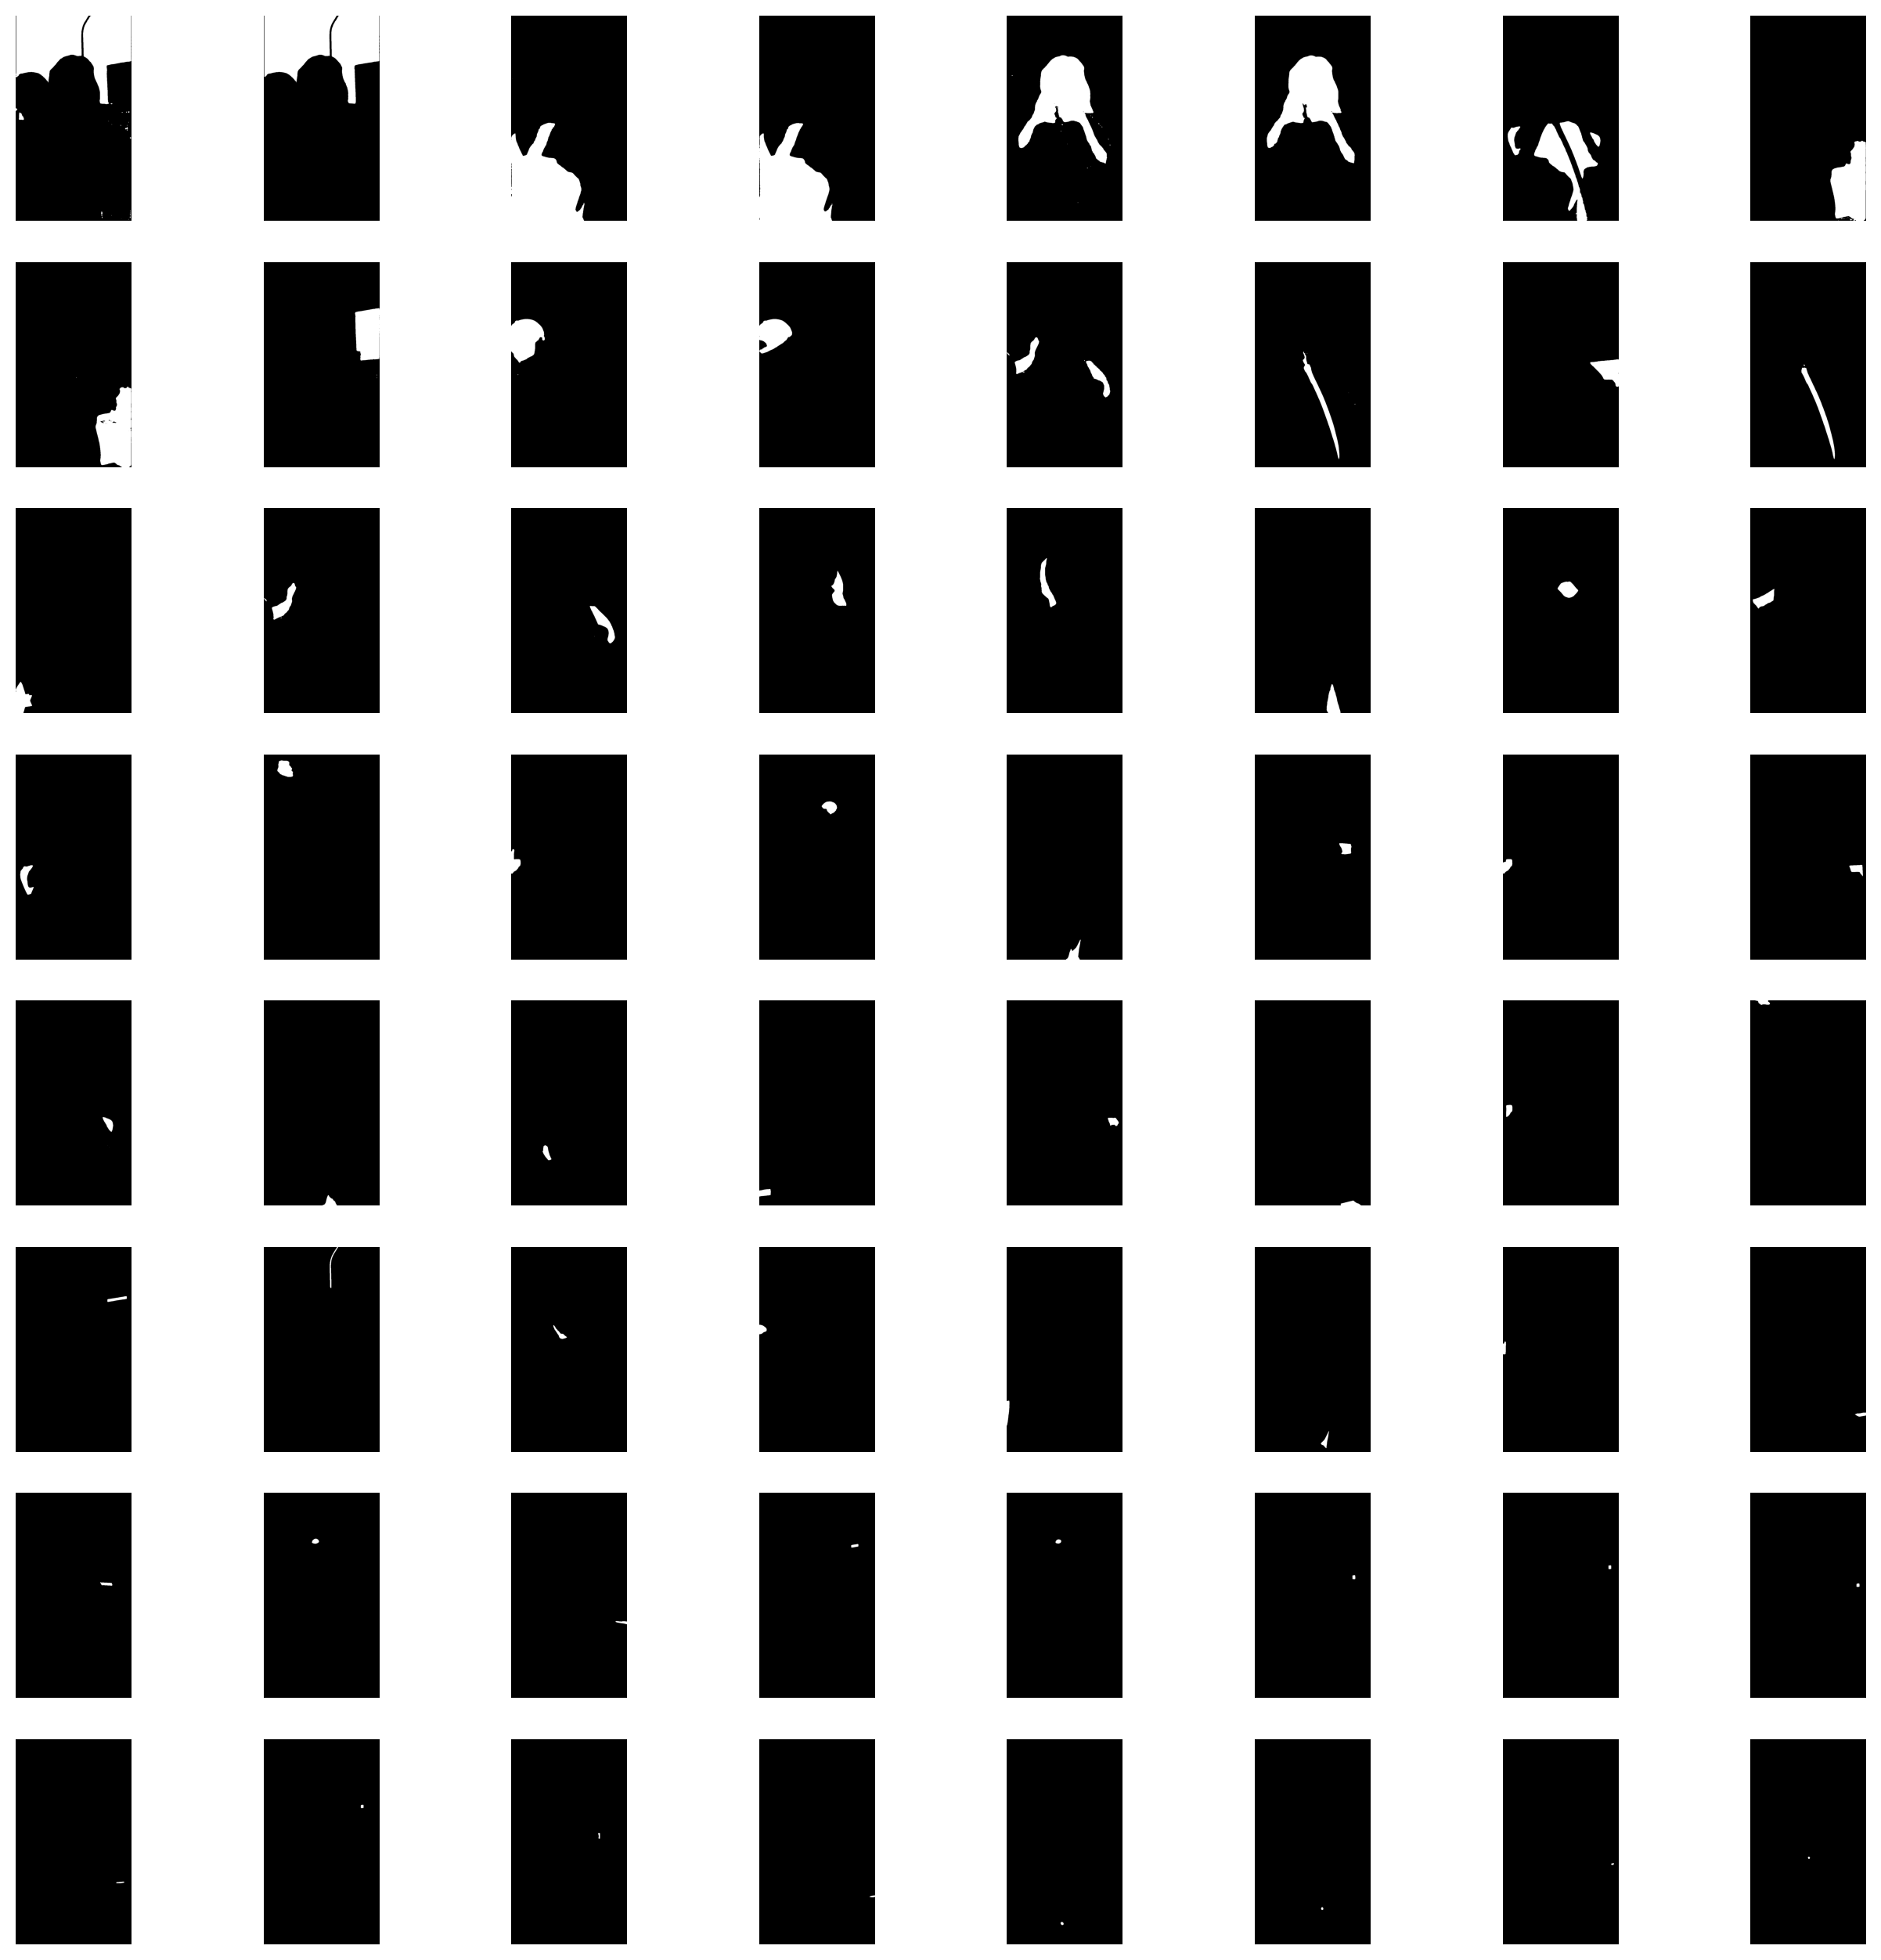

In [13]:
masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]
sv.plot_images_grid(images=masks, grid_size=(8, int(len(masks) / 8)), size=(16, 16))

In [14]:
mask_predictor = SamPredictor(sam)

In [15]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [17]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [18]:
widget.bboxes

[{'x': 72, 'y': 247, 'width': 553, 'height': 676, 'label': ''}]

In [19]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [20]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


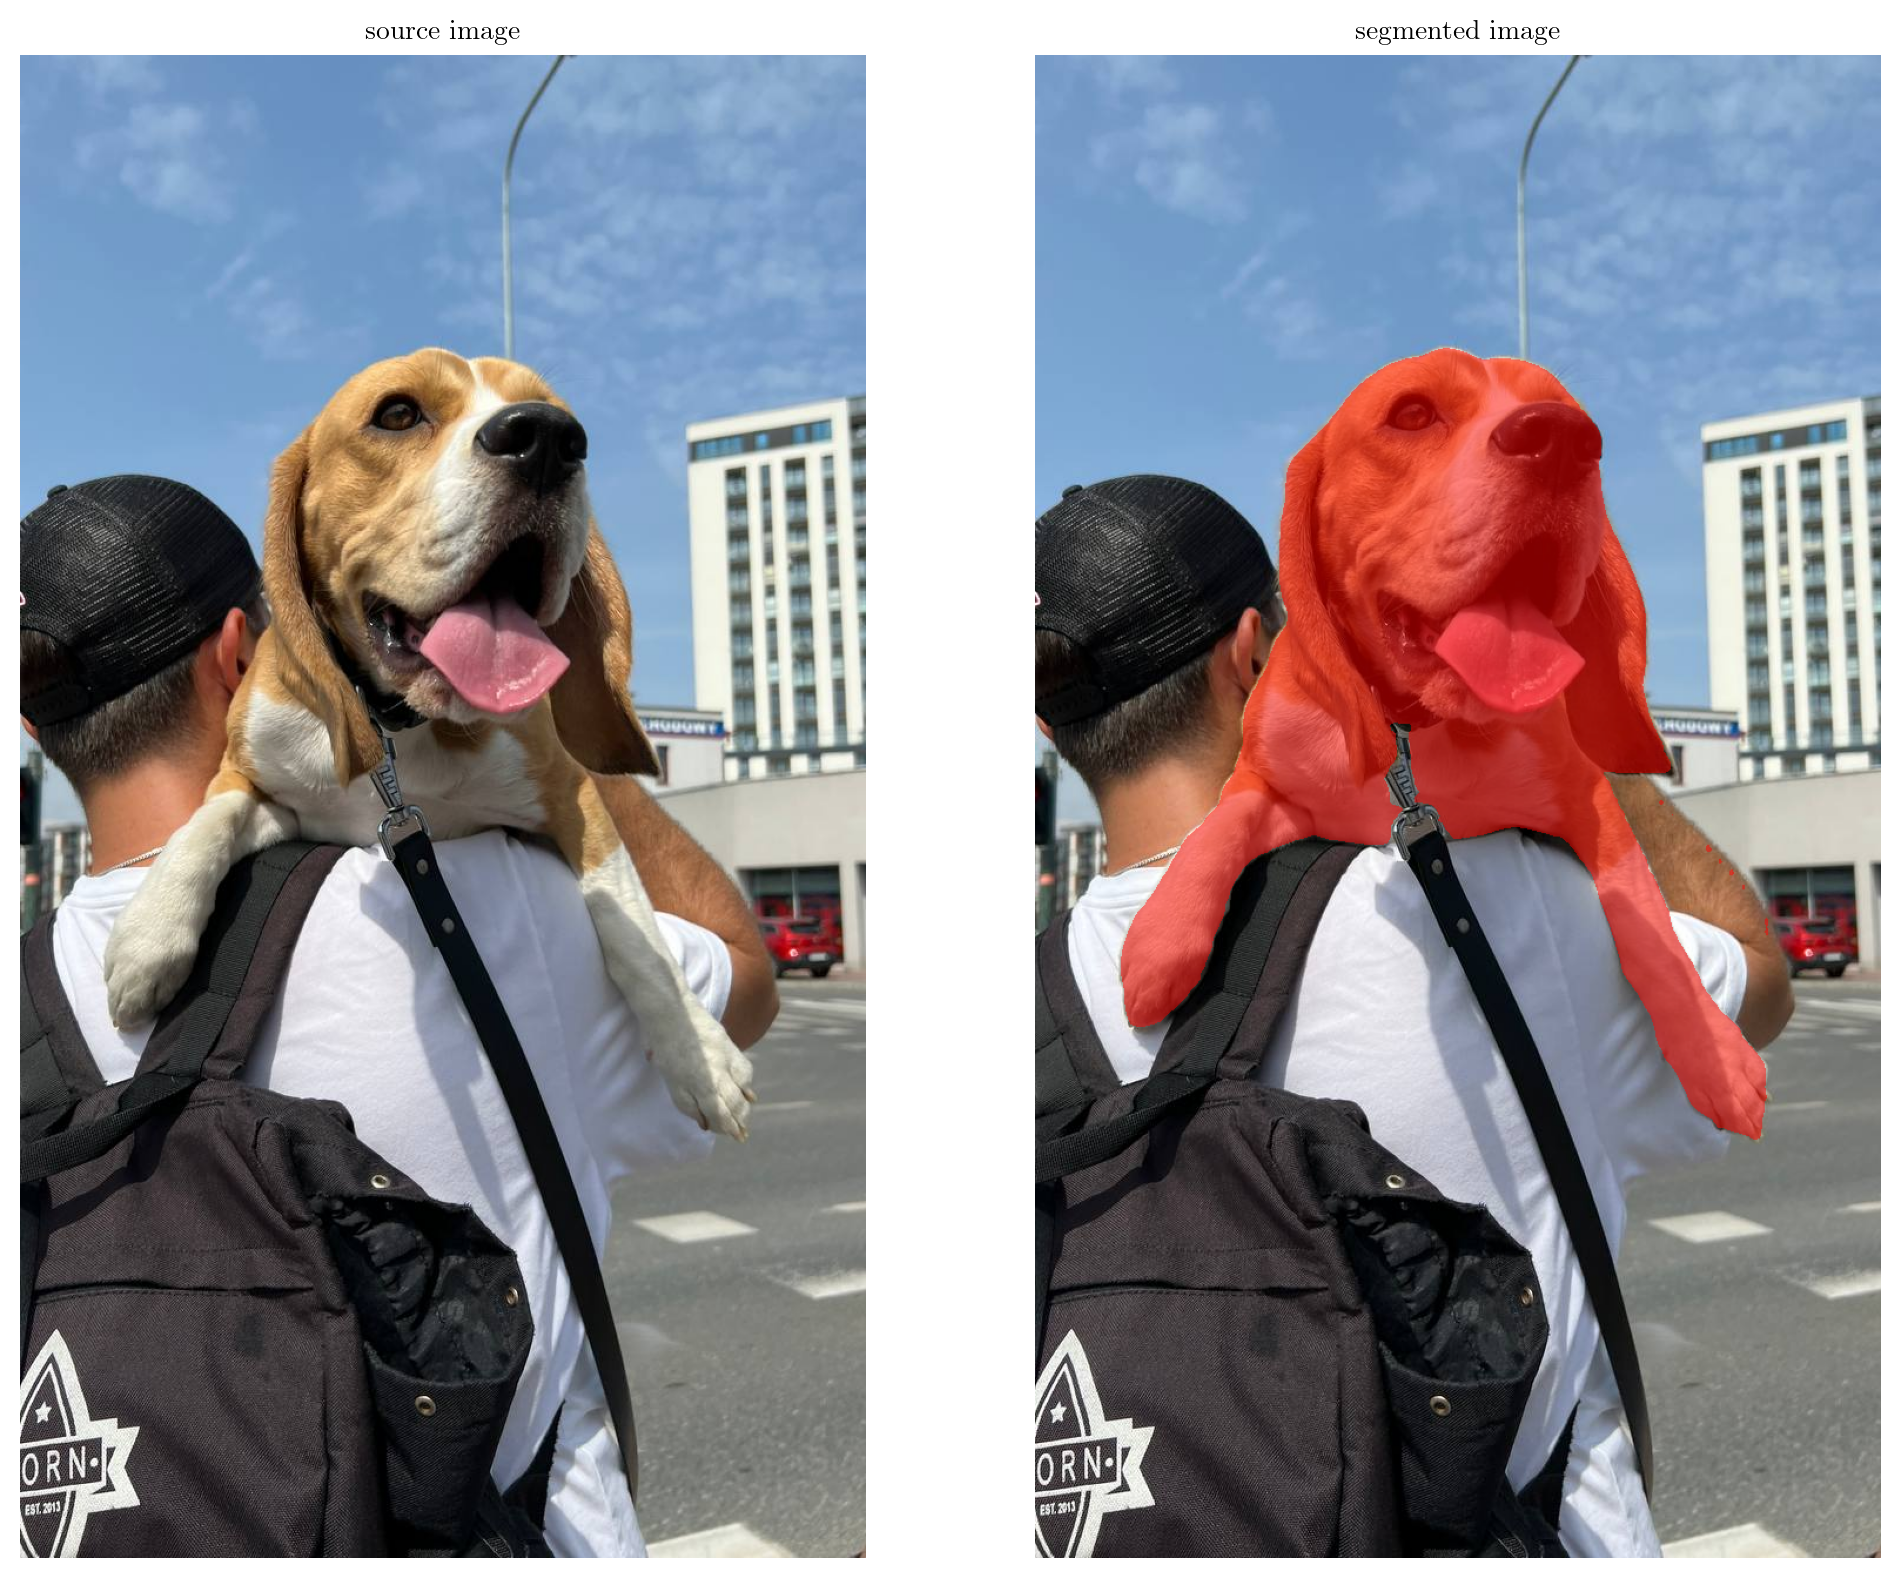

In [38]:
box_annotator = sv.BoundingBoxAnnotator(color=sv.Color.RED)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr.copy(), segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)